Suguru Maker/analisys/solver/grapher

Suguru is a sudoku like game where you solve a n*p grid filled by 1 - k size zones containing number from 1 to the zone size. 

a number cannot be touching (meaning in a 3*3 grid centered on a number, that number cannot be present again)

In [1]:
import numpy as np
import operator
import random

Suguru Maker

In [2]:
def is_valid(index : tuple, shape : tuple):

    return (0 <= index[0] < shape[0] and
            0 <= index[1] < shape[1])

In [3]:
def get_neighboors(position :tuple, shape : tuple):
    neighboors = []
    # adds position in neighboors remove how ? 
    for i in range(-1, 2):
        for j in range(-1, 2):
            if is_valid((position[0]+i,position[1]+j),shape):
                neighboors.append((position[0]+i,position[1]+j))
    neighboors.remove(position)
    return neighboors


In [4]:
def get_positions_snail(positions :np.array , grid : np.array, shape :tuple):
    directions = [np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])]
    direction = 0
    pos = (0,0)
    # old_pos = positions[0]
    # positions[1] = old_pos + directions[direction]
    # pos = positions[1]
    # grid[*old_pos] = 1
    grid[*pos] = 1
    i=1
    positions[0] = pos
    while i < len(positions):
        if is_valid(pos + directions[(direction+1)%4],shape):
        # i.e can be seen as if the snail can coil more ( that is_valid is techniacally always true except if we start on the left row )
            if grid[tuple(pos + directions[(direction+1)%4])] == 0:
                pos = pos + directions[(direction+1)%4]
                positions[i] = pos
                grid[*pos] = 1
                direction = (direction+1)%4
                i += 1
            
            elif is_valid(pos + directions[direction],shape):
                if grid[tuple(pos + directions[direction])] == 0:
                    pos = pos + directions[direction]
                    positions[i] = pos
                    grid[*pos] = 1
                    i += 1

                else:
                    # goes over previous values ( to see the scenario just imagine a snail path that starts with an offset from the center)
                    pos = pos + directions[direction]
            else:
                # turns at a dead end ( also to see the scenario just imagine a snail path that starts with an offset from the center)
                direction = (direction+1)%4
        else: 
            direction = (direction+1)%4
    return positions, grid
                

                
            




In [5]:
def get_neighboor_line(prev :tuple , grid : np.array, shape :tuple):
    # lots of optimizations possible here just general architecture useless calculus and verif but who cares
    # goes right then down 
    val = np.copy(prev)
    val[1] +=1 
    print("val",val)

    if is_valid(val,shape):
        #checks if this lands in the suguru grid

        if not(grid[*val]):
            #checks if there is a value assigned there
            return val
    else:
        val[1] = 0

        if not(grid[*val]):
            return val
    val[1] = prev[1]
    val[0] += 1 
    if is_valid(val,shape):
        if not(grid[*val]):
            return val
    else:
        val[0] = 0
        if not(grid[*val]):
            return val
    print("ERROR")
    return prev
    




In [6]:
possibilities = [1,5,4]
probabilities_table = [0.4 , 0.31, 0.28, 0.25, 0.22]
probabilities = [probabilities_table[i-1] for i in possibilities]
print(probabilities)

[0.4, 0.22, 0.25]


In [7]:
probabilities = [100 , 50, 25, 12.5, 12.5]

probabilities = [p/sum(probabilities) for p in probabilities]
#use the probabilities table to weight the choices
choice = []

for i in range(10000):
    choice.append(random.choices([1,2,3,4,5], probabilities)[0])

for i in range(1,6):
    print(i, choice.count(i))
#print(choice)

1 4982
2 2538
3 1256
4 602
5 622


In [8]:
def avaliable(value : int, numbers : list):
    return True

    if value == 1:
        return True
    else:
        if value-1 in numbers:
            return(avaliable(value-1, numbers))

In [9]:
def get_possibilities(numbers : list, counter : list):
    #check the values of the neighboors to know which numbers can be added

    ###NOT MATHEMATICALLY 
    
    #we can add a check if all the numbers under present exist in a 3d radius
    
    possibilities = []
    for value in range(1,6):
        if not (value in numbers):
            if value != 1 :
                if avaliable(value, numbers):
                    possibilities.append(value)                    
            else:
                possibilities.append(value)

    return possibilities


In [10]:
def counter_check(counter : list, possibilities : list):
    for value in range(2,6):
        if counter[value-1] >= counter[value-2]:
            if value in possibilities:
                possibilities.remove(value)
    return possibilities

In [11]:
def get_value(possibilities : np.array):
    #we can try equiprob since we only add a 5 in poss if a 4 is present
    probabilities_table = [0.4 , 0.31, 0.28, 0.25, 0.22]
    probabilities = [probabilities_table[i-1] for i in possibilities]
    probabilities = [p/sum(probabilities) for p in probabilities]
    
    return random.choices(possibilities, probabilities)[0]    
        


In [12]:
def path_type(method):
    methods = ["line" ,"snail"]
    if method in methods:
        return method
    else : 
        print("unnamed method switching to line")
        return "line"

In [13]:
def make_numbers(suguru : np.array):
    
    #writes the numbers first hopefully there wont be impossible grids? 
    grid_shape = np.shape(suguru)
    grid_size = grid_shape[0]*grid_shape[1]
    #useless for now ? 
    # average_zone_size = 4
    # zone_number = np.ceil(np.size(suguru)/average_zone_size)

    # pick a random spot throw a 1
    # adding a -1 here doesnt change a thing factually just makes it easier to encode snail for now
    # slows very very very slightly by adding 2 operations in the whole calculus  
    start_x = np.random.randint(grid_shape[0]-1)
    start_y = np.random.randint(grid_shape[1]-1)

    suguru[start_x][start_y] = 1

    grid = np.zeros(grid_shape)
    #grid gets allocated positions
    # allocation_type = "line"
    # technique = "line"
    technique = "snail"
    technique = path_type(technique)
    i = 0
    position = (start_x, start_y)
    positions = np.zeros((64,2)).astype(int)
    positions[0] = position

    if technique == "line":
        for i in range (1,64):
            positions[i] = (get_neighboor_line(positions[i-1], grid, grid_shape)) 
            grid[*positions[i]] = 1
    if technique == "snail" : 
        positions, grid = get_positions_snail(positions, grid, grid_shape)
        

    i = 0
    #the counter is detrimental with snail as it enforces a pattern i.e 2 is always gonna be the 6th value added. 
    counter = [0,0,0,0,0]

    while i<grid_size:
        
        # position = get_neighboor_line(position,grid, grid_shape)

        #pick a neighboor
        #assess possible values (if nothing possible here i-e 1-5 is taken then what?) what if snail shape allocation ? should work since no more than 4 neighbors max ? 
        #can do snail-like allocation from random startr point technically #most arranged allocation techniques should work, while random based ones are unsafe
        #distribution will be weighted to have more 1s in the firstly elected part likely ?
        position = tuple(positions[i])
        neighboors = get_neighboors(position, grid_shape)
        numbers = []
        for neighboor in neighboors:
            numbers.append(int(suguru[neighboor]))
        possibilities = get_possibilities(numbers, counter)
        if len(counter_check(counter, possibilities)) != 0:
            value = get_value(possibilities)
        else: 
            value = 0
            print("ERROR")
        counter[value-1] += 1
        suguru[position] = value
        grid[position] = 1

    #allocate values
    
        i+=1

    print(suguru)
    return suguru

    
    

In [14]:
 
def make_suguru(size = 8):
    # makes a Filled Suguru grid 
    global suguru
    print(suguru)
    if 2 < size < 14 : 
        # suguru = np.zeros((size,size)).astype(int)
        suguru = make_numbers(suguru)
    else:
         suguru = np.zeros
    return suguru

In [15]:
# size = 8
# suguru = np.zeros((8,8)).astype(int)

# suguru = make_suguru(8)




In [16]:
suguru = np.zeros((8,8)).astype(int)
suguru = make_suguru(8)
count = 0
while (np.sum(suguru==0) != 0 ):
    count += 1
    suguru = np.zeros((8,8)).astype(int)
    suguru = make_suguru(8)



[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
[[1 0 1 3 1 4 2 1]
 [2 3 2 4 2 0 3 0]
 [5 4 1 0 3 1 4 1]
 [1 3 2 4 2 0 2 0]
 [2 0 0 1 3 1 3 1]
 [1 4 3 0 4 2 4 2]
 [3 2 1 2 3 1 3 1]
 [1 5 4 5 4 5 4 2]]
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
[[1 5 2 1 2 1 4 1]
 [2 3 0 4 3 0 3 2]
 [4 1 0 2 0 2 4 1]
 [0 0 3 1 4 0 3 2]
 [3 1 0 2 3 1 4 1]
 [0 2 4 1 4 2 0 2]
 [4 1 3 2 3 1 0 1]
 [3 2 0 1 0 0 2 3]]
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
ERROR
[[1 5 1

In [17]:
print(count)
print(suguru)

for i in range(1,6):
    print(f"number of {i}s : {np.sum(suguru==i)}")
    

15
[[1 5 1 3 1 3 1 3]
 [2 3 2 4 2 5 2 5]
 [1 4 1 3 1 3 4 3]
 [2 3 2 4 2 5 2 1]
 [1 5 1 5 3 4 3 4]
 [4 2 4 2 1 5 1 2]
 [1 3 1 5 4 2 3 5]
 [4 2 4 2 1 5 1 2]]
number of 1s : 16
number of 2s : 15
number of 3s : 12
number of 4s : 11
number of 5s : 10


In [24]:
# zone generator
def generate_zones(suguru : np.array):
    # generates zones for a suguru grid
    shape = np.shape(suguru)
    zones_count = [0,0,0,0,0]
    zones = []
    for i in range(0,5):
        zones_count[i] = np.sum(suguru==i+1)
    for i in range(0,5):
        neutral = [(-1, -1)] * (i + 1)
        for k in range(zones_count[i]-zones_count[i+1] if i != 4 else zones_count[i]):
            zones.append(neutral)
    
    return zones

In [25]:
print(generate_zones(suguru))

[[(-1, -1)], [(-1, -1), (-1, -1)], [(-1, -1), (-1, -1)], [(-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)], [(-1, -1), (-1, -1), (-1, -1), (-1, -1), (-1, -1)]]


[]

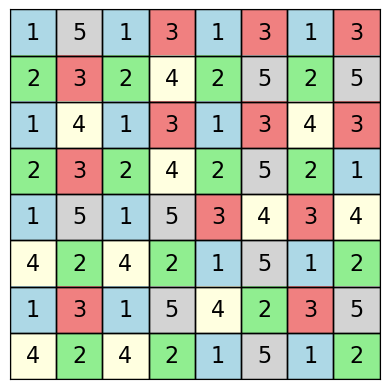

In [ ]:


#printing the current suguru grid in real life 

#lets make it an image with proper cases 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
fig, ax = plt.subplots()
# Create a color map
cmap = mcolors.ListedColormap(['white', 'lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgrey'])
bounds = [0,1,2,3,4,5,6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Create a grid
ax.imshow(suguru, cmap=cmap, norm=norm)
# Create a grid of squares
for i in range(suguru.shape[0]):
    for j in range(suguru.shape[1]):
        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
        if suguru[i, j] != 0:
            ax.text(j, i, str(suguru[i, j]), color='black', fontsize=16, ha='center', va='center')

ax.set_xticks([])
ax.set_yticks([])


COde currently can generate valid grids.
However how to dfetermine zones that work 1 
How to determine if current grid is one that is valid ? (either check if that one is valid or mathematicaaly prove it is)

[5 3 0 0 0 0 0 0]


In [ ]:
def get_possible_zones(suguru : np.array, grid : np.array, sizes : list, pos : tuple):
    value = suguru[pos]
    neighboors = get_neighboors(pos, np.shape(suguru))
    

In [ ]:
def evaluate_zones(suguru : np.array, zones : list):
    shape = np.shape(suguru)
    grid = np.ones(shape)
    ongoing = grid * suguru
    pos = ongoing.where(ongoing == 5)[0]
    